In [36]:
import torch
import dill
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'
    
from src.ode_PINN_hardBC import ODE_PINN_HARDBC
from src.first_order_odesys_PINN_hardBC import ORDER1_ODESYS_PINN_HARDBC
from src.second_order_odesys_PINN_hardBC import ORDER2_ODESYS_PINN_HARDBC
from src.ode_PINN_softBC import ODE_PINN_SOFTBC
from src.ode_PINN_adaptCollectionPoint import  ODE_PINN_AdaptiveCollectionPoint

from src.pde_PINN_hardBC_elliptic import PDE_PINN_HARDBC_ELLIPTIC
from src.pde_PINN_wave import PDE_PINN_WAVE

# ODE

In [56]:
def Savepickle(obj, doc_path):
    with open(doc_path, 'wb') as file:
        dill.dump(obj, file)     

def Readpickle(doc_path):
    with open(doc_path, 'rb') as file:
        return dill.load(file)
    
def SaveModel(model, path): 
    if model.model_type == 'ODE_PINN_SOFTBC':
        data = {'model_type': model.model_type,
                'f': model.f, 
                'bound' : (model.lb,model.ub),
                'BC' : model.BC , 
                'lambdas' : model.lambdas,
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}
    else:
        data = {'model_type': model.model_type,
                'f': model.f, 
                'bound' : (model.lb,model.ub),
                'BC' : model.BC , 
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}
    Savepickle(data, path)
    
def LoadModel(path):
    data = Readpickle(path)
    
    try:
        rff_B = data['rff_B']
    except:
        rff_B = None
    
    if data['model_type'] == 'ODE_PINN_HARDBC':
        model = ODE_PINN_HARDBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
        
    elif data['model_type'] == 'ODE_PINN_SOFTBC':
        model = ODE_PINN_SOFTBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], lambdas=data['lambdas'],
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
        
    elif data['model_type'] == 'ODE_PINN_AdaptiveCollectionPoint':
        model = ODE_PINN_AdaptiveCollectionPoint(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
        
    elif data['model_type'] == 'ORDER1_ODESYS_PINN_HARDBC':
        model = ORDER1_ODESYS_PINN_HARDBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
        
    elif data['model_type'] == 'ORDER2_ODESYS_PINN_HARDBC':
        model = ORDER2_ODESYS_PINN_HARDBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
     
    model.load_state_dict(data['para_dict'])
    model.validate_loss = data['validate_loss']
    model.train_loss = data['train_loss']
    model.L2_loss = data['L2_loss']
    return model

def moving_average(x, half_window_size):
    res = []
    x = np.array(x)
    for i in range(len(x)):
        if i == 0:
            res.append(x[i]) 
        elif i < half_window_size:
            res.append(x[0:2*i+1].mean())
        elif i <= len(x)-1-half_window_size:
            res.append(x[i-half_window_size:i+half_window_size+1].mean())
        else:
            res.append(x[2*i+1-len(x):].mean())
    return res

## Plot 1

In [ ]:
# Load Model
paths = [ './data/ode_sin_slover_n1_3layer_16unit.pkl',
          './data/ode_sin_slover_n5_3layer_16unit.pkl',
          './data/ode_sin_slover_n5_5layer_16unit.pkl',
          './data/ode_sin_slover_n5_5layer_32unit.pkl',
          './data/rff_ode_sin_slover_n5_3layer_16unit.pkl' ]

solvers = [LoadModel(path) for path in paths]

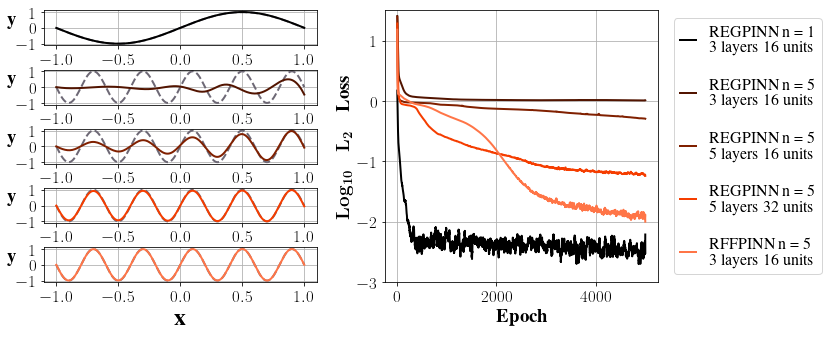

In [71]:
title_fontsize , tick_size , leg_size = 19, 17, 16
fig  = plt.figure(figsize = (11,5))
color   = ['#000000', '#521400', '#802000', '#F53D00', '#FF7547', '#6d6875']

legend  = ['REGPINN  n = 1\n3 layers  16 units',
           'REGPINN  n = 5\n3 layers  16 units',
           'REGPINN  n = 5\n5 layers  16 units',
           'REGPINN  n = 5\n5 layers  32 units',
           'RFFPINN   n = 5\n3 layers  16 units',]

ax_fit  = [plt.subplot(521), plt.subplot(523), plt.subplot(525), plt.subplot(527), plt.subplot(529)]
ax_loss = plt.subplot(122)

true_sol_1 = lambda x:  torch.sin(torch.pi*x)
true_sol_2 = lambda x:  torch.sin(5*torch.pi*x)
x = torch.linspace(-1,1,200).view(-1,1)
x_grid = x.squeeze().detach().numpy()

for i in range(5):
    if i == 0:
        y_gt = true_sol_1(x).squeeze().detach().numpy()
    else:
        y_gt = true_sol_2(x).squeeze().detach().numpy()
    y_hat = solvers[i](x).squeeze().detach().numpy()

    ax_fit[i].plot(x_grid, y_gt, color=color[-1], linewidth=2, linestyle='--')
    ax_fit[i].plot(x_grid, y_hat, color=color[i], linewidth=2, label=legend[i])
    ax_fit[i].grid()
    
    half_window_size = 10
    loss = np.log10(solvers[i].L2_loss)
    loss = moving_average(loss, half_window_size)
    ax_loss.plot(loss, color=color[i], linewidth=2, label=legend[i])
    
    ax_fit[i].tick_params(axis='x', labelsize=tick_size)
    ax_fit[i].tick_params(axis='y', labelsize=tick_size)
    
    if i == 4 :
        ax_fit[i].set_xlabel('\\textbf{x}', fontsize=title_fontsize+5, fontweight='bold')
    ax_fit[i].set_ylabel('\\textbf{y}', fontsize=title_fontsize, fontweight='bold', rotation=0)
    
ax_loss.grid()
ax_loss.set_ylim(-3, 1.5)
ax_loss.tick_params(axis='x', labelsize=tick_size)
ax_loss.tick_params(axis='y', labelsize=tick_size)

leg = ax_loss.legend(loc='center right', bbox_to_anchor=(1.63, 0.5), 
                     fontsize=leg_size, handlelength=1.0, labelspacing=1.4)

ax_loss.set_ylabel('$\mathbf{Log_{10}}$ \ \ \ $\mathbf{L_2}$ \ \ \ \\textbf{Loss}', fontsize=title_fontsize, fontweight='bold')
ax_loss.set_xlabel('\\textbf{Epoch}', fontsize=title_fontsize, fontweight='bold')

plt.subplots_adjust(wspace=0.25, hspace=0.7)
plt.show()

## Plot 2

In [65]:
# Load Model
data = []
for k in range(4):

    if k==3 :
        model  = LoadModel('./data/odesys_slover_exp.pkl')
        y_true = Readpickle('./data/odesys_slover_exp_gt.pkl')
        data.append((model, y_true))
    else:
        paths   = [ './data/ode_slover_BC%dexp%d.pkl'%(k+1,i+1) for i in range(4) ]
        models  = [LoadModel(path) for path in paths]
        y_trues = Readpickle('./data/ode_slover_BC%dexp_gt.pkl'%(k+1))
        data.append((models, y_trues))

true_names_lst  = [['$\mathbf{y_1}$', '$\mathbf{y_2}$', '$\mathbf{y_3}$', '$\mathbf{y_4}$'],
                   ['$\mathbf{y_5}$', '$\mathbf{y_6}$', '$\mathbf{y_7}$', '$\mathbf{y_8}$'],
                   ['$\mathbf{y_5}$', '$\mathbf{y_6}$', '$\mathbf{y_7}$', '$\mathbf{y_8}$'],
                   ['$\mathbf{u}$', '$\mathbf{v}$']]

model_names_lst = [['$\mathbf{y_1}$ PINN', '$\mathbf{y_2}$ PINN', '$\mathbf{y_3}$ PINN', '$\mathbf{y_4}$ PINN'],
                   ['$\mathbf{y_5}$ PINN', '$\mathbf{y_6}$ PINN', '$\mathbf{y_7}$ PINN', '$\mathbf{y_8}$ PINN'],
                   ['$\mathbf{y_5}$ PINN', '$\mathbf{y_6}$ PINN', '$\mathbf{y_7}$ PINN', '$\mathbf{y_8}$ PINN'],
                   ['$\mathbf{u}$ PINN', '$\mathbf{v}$ PINN']]

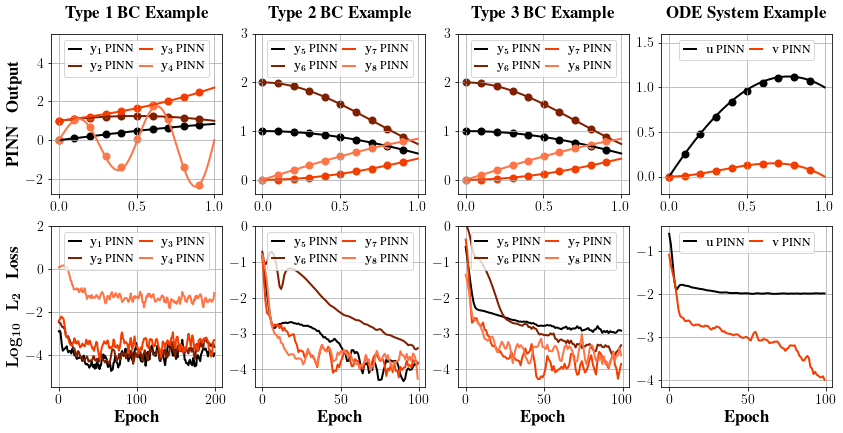

In [70]:
fig, axes = plt.subplots( 2 , 4 , figsize=( 14, 6.5 ) )
title_fontsize = 17
tick_size = 14
leg_size = 12
half_window_size = 1

PINNColor  = ['#000000','#802000','#F53D00','#FF7547']
PINNColor2  = ['#000000','#F53D00']
titles = ['Type 1 BC Example', 'Type 2 BC Example', 'Type 3 BC Example', 'ODE System Example']

for k in range(4):
    
    true_names = true_names_lst[k]
    model_names = model_names_lst[k]
    models , y_trues = data[k]
    
    x = torch.linspace(0,1,200).view(-1,1)
    if k < 3:
        y_trues_ = [ y_trues[i](x).squeeze().detach().numpy() for i in range(4) ]
        y_hats_  = [ models[i](x).squeeze().detach().numpy()  for i in range(4) ]
    else:
        y_trues_ = y_trues(x).detach().numpy()
        y_hats_  = models(x).detach().numpy()
    x = x.squeeze().detach().numpy()
    
    num_lines = []
    if k < 3:
        for i in range(4):
            # Fitting
            axes[0,k].scatter(x[::20], y_trues_[i][::20] , linewidth=2, label=true_names[i], color=PINNColor[i])
            num_line, = axes[0,k].plot(x, y_hats_[i], linewidth=2, label=model_names[i], color=PINNColor[i])
            num_lines.append(num_line) 
            
            # Loss
            loss = np.log10(models[i].L2_loss)[:]
            loss = moving_average(loss, half_window_size)
            axes[1,k].plot(loss, linewidth=2, label=model_names[i], color=PINNColor[i])
    else:
        for i in range(2):
            # Fitting
            axes[0,k].scatter(x[::20], y_trues_[:,i][::20] , linewidth=2, label=true_names[i], color=PINNColor2[i])
            num_line, = axes[0,k].plot(x, y_hats_[:,i], linewidth=2, label=model_names[i], color=PINNColor2[i])
            num_lines.append(num_line) 
            
            # Loss
            loss = np.log10([loss_[i] for loss_ in models.L2_loss])[:]
            loss = moving_average(loss, half_window_size)
            axes[1,k].plot(loss, linewidth=2, label=model_names[i], color=PINNColor2[i])
            
    # Legend         
    axes[0,k].legend(handles=num_lines, handlelength=1, loc='upper center', labelspacing=0.5, columnspacing=0.5,
                        fontsize=leg_size, ncol=2, fancybox=True)
    axes[1,k].legend(loc='upper center', handlelength=1, labelspacing=0.5, columnspacing=0.5,
                        fontsize=leg_size, ncol=2, fancybox=True)

    # Grid & y_lim
    axes[0,k].grid()
    axes[1,k].grid()    
    
    if k == 0:
        axes[0,k].set_ylim(-2.8, 5.5)
        axes[1,k].set_ylim(-5.5, 2)
    elif k == 1 or k == 2:
        axes[0,k].set_ylim(-0.3, 3)
        axes[1,k].set_ylim(-4.5, 0)
    else:
        axes[0,k].set_ylim(-0.2, 1.6)
        
    # xy axes and title
    axes[0,k].tick_params(axis='x', labelsize=tick_size)
    axes[0,k].tick_params(axis='y', labelsize=tick_size)
    axes[1,k].tick_params(axis='x', labelsize=tick_size)
    axes[1,k].tick_params(axis='y', labelsize=tick_size)
    
    axes[0,k].set_title("\\textbf{%s}"%(titles[k]), fontsize=title_fontsize, fontweight='bold', pad=15) 
    axes[1,k].set_xlabel('\\textbf{Epoch}', fontsize=title_fontsize, fontweight='bold') 

axes[0,0].set_ylabel('\\textbf{PINN \ \ Output}', fontsize=title_fontsize, fontweight='bold') 
axes[1,0].set_ylabel('$\mathbf{Log_{10}}$ \\textbf{\ \ $\mathbf{L_2}$ \ \  Loss}', fontsize=title_fontsize, fontweight='bold') 

plt.subplots_adjust(wspace=0.19, hspace=0.2)
plt.show()



# PDE

In [74]:
def Savepickle(obj, doc_path):
    with open(doc_path, 'wb') as file:
        dill.dump(obj, file)     

def Readpickle(doc_path):
    with open(doc_path, 'rb') as file:
        return dill.load(file)
    
def SaveModel(model, path): 
    if model.model_type == 'PDE_PINN_HARDBC_ELLIPTIC':
        data = {'model_type': model.model_type,
                'f': model.f, 
                'rec_bound' : model.rec_bound,
                'BC' : model.BC , 
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}
        
    elif model.model_type == 'PDE_PINN_WAVE':
        data = {'model_type': model.model_type,
                'paras': (model.c , model.a , model.b , model.T),
                'BC': (model.g, model.phi),
                'lambdas': model.lambdas,
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}  
    Savepickle(data, path)
    
def LoadModel(path):
    data = Readpickle(path)
    
    try:
        rff_B = data['rff_B']
    except:
        rff_B = None
    
    if data['model_type'] == 'PDE_PINN_HARDBC_ELLIPTIC':
        model = PDE_PINN_HARDBC_ELLIPTIC(f=data['f'], rec_bound=data['rec_bound'], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
        
    elif data['model_type'] == 'PDE_PINN_WAVE':
        model =  PDE_PINN_WAVE(paras=data['paras'], BC=data['BC'], lambdas=data['lambdas'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
          
    model.load_state_dict(data['para_dict'])
    model.validate_loss = data['validate_loss']
    model.train_loss = data['train_loss']
    model.L2_loss = data['L2_loss']
    return model

def moving_average(x, half_window_size):
    res = []
    x = np.array(x)
    for i in range(len(x)):
        if i == 0:
            res.append(x[i]) 
        elif i < half_window_size:
            res.append(x[0:2*i+1].mean())
        elif i <= len(x)-1-half_window_size:
            res.append(x[i-half_window_size:i+half_window_size+1].mean())
        else:
            res.append(x[2*i+1-len(x):].mean())
    return res

## Plot 1

In [ ]:
# Load Model
Elliptic_Solver = LoadModel('./data/PDE_Elliptic_Solver.pkl')
Wave_Solver = LoadModel('./data/PDE_Wave_Solver.pkl')
Elliptic_true = lambda xy : (torch.sin(2*torch.pi*xy[:,0]) * torch.sin(3*torch.pi*xy[:,1])).unsqueeze(dim=1)

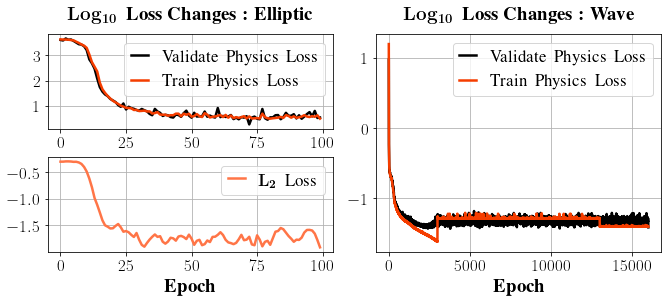

In [52]:
## Plot loss changes
fig, ax = plt.subplots( figsize=( 11 , 4 ) )
title_fontsize = 19
tick_size = 17
leg_size  = 17

ax  = [plt.subplot(221), plt.subplot(223), plt.subplot(122)]

ax[0].plot(np.log10(Elliptic_Solver.validate_loss), label='Validate\ \ Physics\ \ Loss', linewidth=2.5, color='#000000')    
ax[0].plot(np.log10(Elliptic_Solver.train_loss), label='Train\ \ Physics\ \ Loss', linewidth=2.5, color='#f53d00')    
ax[1].plot(moving_average(np.log10(Elliptic_Solver.L2_loss),2), label='$\mathbf{L_2}$\ \ Loss', linewidth=2.5, color='#ff7547')   

ax[2].plot(moving_average(np.log10(Wave_Solver.validate_loss), 5)[:-1],
           label='Validate\ \ Physics\ \ Loss', linewidth=2.5, color='#000000')    
ax[2].plot(moving_average(np.log10(Wave_Solver.train_loss), 2)[:-1],
           label='Train\ \ Physics\ \ Loss', linewidth=2.5, color='#f53d00')    

for i in range(3):
    ax[i].grid()
    ax[i].legend(loc='upper right', fontsize=leg_size, handlelength=1.0)
    
    if i == 0 :
        ax[i].set_title('$\mathbf{Log_{10}}$ \ \\textbf{Loss Changes : Elliptic}', fontsize=title_fontsize, fontweight='bold', pad=15)
    if i == 1 :
        ax[i].set_xlabel('\\textbf{Epoch}', fontsize=title_fontsize, fontweight='bold') 
    elif i == 2 :
        ax[i].set_title('$\mathbf{Log_{10}}$ \ \\textbf{Loss Changes : Wave}', fontsize=title_fontsize, fontweight='bold', pad=15)
        ax[i].set_xlabel('\\textbf{Epoch}', fontsize=title_fontsize, fontweight='bold') 
    
    ax[i].tick_params(axis='x', labelsize=tick_size)
    ax[i].tick_params(axis='y', labelsize=tick_size)
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

## Plot2

In [75]:
# Load Model
Elliptic_Solver = LoadModel('./data/PDE_Elliptic_Solver.pkl')
Elliptic_true = lambda xy : (torch.sin(2*torch.pi*xy[:,0]) * torch.sin(3*torch.pi*xy[:,1])).unsqueeze(dim=1)

x = np.linspace(Elliptic_Solver.rec_bound[0], Elliptic_Solver.rec_bound[1], 100)
y = np.linspace(Elliptic_Solver.rec_bound[2], Elliptic_Solver.rec_bound[3], 100)
X , Y = np.meshgrid(x,y)
XY = torch.tensor( np.column_stack((X.flatten(),Y.flatten())), dtype=torch.float32 )
recover_dim = (100,100)

U_hat = Elliptic_Solver(XY).detach().numpy().reshape(recover_dim)
U_true = Elliptic_true(XY).detach().numpy().reshape(recover_dim)
U_AbsError = np.abs(U_true - U_hat)
U_SqError  = U_AbsError**2
X_Slice_L2Error = np.sqrt(np.trapz(U_SqError, Y, dx=1.0, axis=0)) # x
Y_Slice_L2Error = np.sqrt(np.trapz(U_SqError, X, dx=1.0, axis=1)) # y

title_fontsize = 18 ; tick_size = 16
cbar_tick_size = 16 ; leg_size = 17  
cmap = 'RdBu_r'

data_lst = [U_hat, U_AbsError, X_Slice_L2Error, Y_Slice_L2Error]

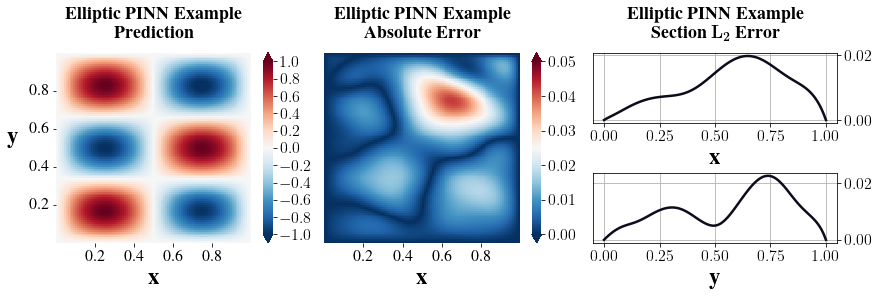

In [76]:
fig = plt.subplots(figsize=(14,3.5))
axes = [plt.subplot(131), plt.subplot(132), plt.subplot(233), plt.subplot(236)]

colorbar_nbins = [10, 5]
colorbar_vmax  = [ 1, 0.05]
colorbar_vmin  = [-1, 0.00]

for i in range(4) :
    if i == 0 or i == 1 :
        hp = sns.heatmap( np.flipud(data_lst[i]), ax=axes[i], 
                          vmax=colorbar_vmax[i], vmin=colorbar_vmin[i], cmap=cmap, # 'magma'
                          cbar_kws={'orientation': 'vertical', 'extend': 'both'})
        
        colorbar = hp.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=cbar_tick_size)
        colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=colorbar_nbins[i]))
        
        axes[i].set_xticks(np.append(np.arange(0, 100, 20),99.5)[1:-1])
        axes[i].set_xticklabels(np.append(np.round(x,1)[::20],1.0)[1:-1])
        axes[i].set_xlabel('\\textbf{x}', fontsize=title_fontsize+5, fontweight='bold') 
        
        if i == 0 :
            axes[i].set_yticks(np.append(np.arange(0, 100, 20),100)[1:-1])
            axes[i].set_yticklabels(np.append(np.round(x,1)[::20],1.0)[::-1][1:-1])
            axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)
            axes[i].set_ylabel('\\textbf{y}', fontsize=title_fontsize+5, fontweight='bold', rotation=0, labelpad=16)
            axes[i].set_title('\\textbf{Elliptic PINN Example}\n\\textbf{Prediction}', fontsize=title_fontsize, fontweight='bold', pad=15) 
            
        else :
            axes[i].set_yticks([])    
            axes[i].set_title('\\textbf{Elliptic PINN Example}\n\\textbf{Absolute Error}', fontsize=title_fontsize, fontweight='bold', pad=15) 
            
    else :
        if i == 2 :
            axes[i].plot(x, data_lst[i], label='Validate  Physics  Loss', linewidth=2.5, color='#0d0c1d')
            axes[i].set_xlabel('\\textbf{x}', fontsize=title_fontsize+5, fontweight='bold') 
            axes[i].set_title('\\textbf{Elliptic PINN Example}\n\\textbf{Section} $\mathbf{L_2}$ \\textbf{Error}', fontsize=title_fontsize, fontweight='bold', pad=15) 
        else :
            axes[i].plot(y, data_lst[i], label='Validate  Physics  Loss', linewidth=2.5, color='#0d0c1d')  
            axes[i].set_xlabel('\\textbf{y}', fontsize=title_fontsize+5, fontweight='bold')  
        axes[i].grid()
        axes[i].yaxis.tick_right()

    axes[i].tick_params(axis='y', labelsize=tick_size)
    axes[i].tick_params(axis='x', labelsize=tick_size)

plt.subplots_adjust(wspace=0.1, hspace=0.7)
plt.show()

## Plot 3

In [77]:
# Load Model
Wave_Solver = LoadModel('./data/PDE_Wave_Solver.pkl')
XYT_tensor = Wave_Solver.generate_grid(n_each_axis=100)
sol_pred = Wave_Solver(XYT_tensor).reshape(100,100,100).detach().numpy()
sol_true = Wave_Solver.true_sol(XYT_tensor, k=20).reshape(100,100,100).detach().numpy()

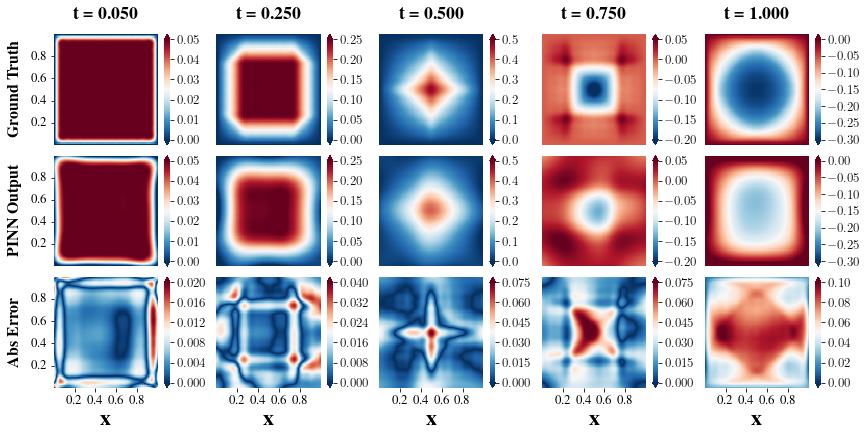

In [78]:
title_fontsize = 18 ; tick_size = 13
cbar_tick_size = 13 ; leg_size = 13
label_fontsize = 16 ; cmap = 'RdBu_r'

fig, axes = plt.subplots( 3, 5 , figsize=( 14, 6.5 ) )
select = [1,5,10,15,20]

# colorbar_nbins = [10, 5.00]
colorbar_nbins = [6, 6, 6, 6, 6]
err_colorbar_nbins = [6, 6, 6, 6, 6]
colorbar_vmax  = [0.05, 0.25, 0.50, 0.05, 0.00]
colorbar_vmin  = [0.00, 0.00, 0.00, -0.2, -0.3]
err_colorbar_vmax  = [0.02, 0.04, 0.075, 0.075, 0.1]

for j in range(5):

    u_true = sol_true[select[j]]
    u_pred = sol_pred[select[j]]
    abs_er = np.abs(u_true-u_pred)
    
    axes[0,j].set_title('\\textbf{t = %.3f}'%(select[j]/20), fontsize=title_fontsize, fontweight='bold', pad=15) 

    hp1 = sns.heatmap(np.flipud(u_true), ax=axes[0,j], cmap=cmap, vmax=colorbar_vmax[j], vmin=colorbar_vmin[j],
                            cbar_kws={'orientation': 'vertical', 'extend': 'both'})
    hp2 = sns.heatmap(np.flipud(u_pred), ax=axes[1,j], cmap=cmap, vmax=colorbar_vmax[j], vmin=colorbar_vmin[j],
                            cbar_kws={'orientation': 'vertical', 'extend': 'both'})
    hp3 = sns.heatmap(np.flipud(abs_er), ax=axes[2,j], cmap=cmap, vmax=err_colorbar_vmax[j], vmin=0, 
                            cbar_kws={'orientation': 'vertical', 'extend': 'both'})
    
    colorbar = hp1.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=cbar_tick_size)
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=colorbar_nbins[j]))
    
    colorbar = hp2.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=cbar_tick_size)
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=colorbar_nbins[j]))
    
    colorbar = hp3.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=cbar_tick_size)
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=err_colorbar_nbins[j]))
    
    for i in range(3):
        if i == 2:
            axes[i,j].set_xticks(np.append(np.arange(0, 100, 20),99.5)[1:-1])
            axes[i,j].set_xticklabels(np.append(np.round(x,1)[::20],1.0)[1:-1])
            axes[i,j].set_xlabel('\\textbf{x}', fontsize=22, fontweight='bold') 
        else:
            axes[i,j].set_xticks([])    
            
        if j == 0 :
            axes[i,j].set_yticks(np.append(np.arange(0, 100, 20),100)[1:-1])
            axes[i,j].set_yticklabels(np.append(np.round(x,1)[::20],1.0)[::-1][1:-1])
            axes[i,j].set_yticklabels(axes[i,j].get_yticklabels(), rotation=0)
            
            axes[0,j].set_ylabel('\\textbf{Ground Truth}', fontsize=label_fontsize, fontweight='bold', labelpad=9)
            axes[1,j].set_ylabel('\\textbf{PINN Output}', fontsize=label_fontsize, fontweight='bold', labelpad=9)
            axes[2,j].set_ylabel('\\textbf{Abs Error}', fontsize=label_fontsize, fontweight='bold', labelpad=9)
            
        else:
            axes[i,j].set_yticks([])    
            
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        axes[i,j].tick_params(axis='x', labelsize=tick_size)

plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.show()